In [970]:
!pip install hnswlib polars  --quiet
!pip install shap gradio --quiet

In [971]:
# Suppress warnings
import re
import warnings

import gradio as gr
import hnswlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import shap
import xgboost as xgb
from scipy.spatial import distance
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")

In [972]:
# Use alternative encoding to avoid UnicodeDecodeError
# Use alternative encoding to avoid UnicodeDecodeError
df = pl.read_csv('../data/fy2022_archived_opportunities.csv', encoding='latin-1')

# Calculate 10% of the total number of rows
sample_size = int(df.height * 0.1)

# Get a 10% random sample of the data
df = df.sample(n=sample_size, with_replacement=False, shuffle=True, seed=42)

print(df)

shape: (32_303, 47)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ NoticeId  ┆ Title     ┆ Sol#      ┆ Departmen ┆ … ┆ CountryCo ┆ Additiona ┆ Link      ┆ Descript │
│ ---       ┆ ---       ┆ ---       ┆ t/Ind.Age ┆   ┆ de        ┆ lInfoLink ┆ ---       ┆ ion      │
│ str       ┆ str       ┆ str       ┆ ncy       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---      │
│           ┆           ┆           ┆ ---       ┆   ┆ str       ┆ str       ┆           ┆ str      │
│           ┆           ┆           ┆ str       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ bc5e5f04c ┆ 15--FAIRI ┆ N0038322R ┆ DEPT OF   ┆ … ┆ USA       ┆           ┆ https://s ┆          │
│ 916465799 ┆ NG,AIRCRA ┆ F342      ┆ DEFENSE   ┆   ┆           ┆           ┆ am.gov/op ┆          │
│ 33a4c0bdc ┆ FT        ┆           ┆           ┆   ┆           ┆      

In [973]:
# Function to clean column names
def clean_names(df):
    """
    Cleans column names of a Polars DataFrame by removing special characters,
    converting to lowercase, and replacing spaces with underscores.

    Args:
        df: Polars DataFrame

    Returns:
        Polars DataFrame with cleaned column names.
    """
    df.columns = [re.sub(r'\W+', '_', col).lower() for col in df.columns]
    return df

# Load your DataFrame
# df2023 = pl.read_csv('your_dataset.csv')  # Replace with your actual data loading method

# Clean column names
df2022 = clean_names(df)

In [974]:
# Calculate the number of unique values and missing values for each column
summary = pl.DataFrame({
    'column': df2022.columns,
    'unique_values': [df2022[col].n_unique() for col in df2022.columns],
    'missing_values': [df2022[col].null_count() for col in df2022.columns]
})

# Display the summary
print(summary)

shape: (47, 3)
┌───────────────────────┬───────────────┬────────────────┐
│ column                ┆ unique_values ┆ missing_values │
│ ---                   ┆ ---           ┆ ---            │
│ str                   ┆ i64           ┆ i64            │
╞═══════════════════════╪═══════════════╪════════════════╡
│ noticeid              ┆ 32303         ┆ 0              │
│ title                 ┆ 24153         ┆ 0              │
│ sol_                  ┆ 29539         ┆ 0              │
│ department_ind_agency ┆ 69            ┆ 0              │
│ cgac                  ┆ 66            ┆ 0              │
│ …                     ┆ …             ┆ …              │
│ zipcode               ┆ 1066          ┆ 0              │
│ countrycode           ┆ 43            ┆ 0              │
│ additionalinfolink    ┆ 1             ┆ 0              │
│ link                  ┆ 32303         ┆ 0              │
│ description           ┆ 26677         ┆ 0              │
└───────────────────────┴───────────────┴

In [975]:
# List of categorical columns
categorical_cols = ['title', 'sol_', 'department_ind_agency', 'sub_tier', 'fpds_code', 'office',
                     'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 
                     'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 
                     'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'awardnumber',
                     'awarddate', 'awardee', 'state', 'city', 'zipcode', 'countrycode', 'description']

# Convert all categorical columns to strings
df2022 = df2022.with_columns([pl.col(col).cast(pl.Utf8) for col in categorical_cols])

In [976]:
# Apply LabelEncoder to each categorical column
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df2022 = df2022.with_columns([pl.Series(col, le.fit_transform(df2022[col].to_list()))])
    label_encoders[col] = le

# Ensure numerical columns are in the correct format
df2022

noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,type,basetype,archivetype,archivedate,setasidecode,setaside,responsedeadline,naicscode,classificationcode,popstreetaddress,popcity,popstate,popzip,popcountry,active,awardnumber,awarddate,award_,awardee,primarycontacttitle,primarycontactfullname,primarycontactemail,primarycontactphone,primarycontactfax,secondarycontacttitle,secondarycontactfullname,secondarycontactemail,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,i64
"""bc5e5f04c91646579933a4c0bdc456…",438,14850,13,17,45,54,942,1266,22481,0,0,2,363,0,0,0,0,62,0,0,0,0,0,"""No""",2185,356,"""1165526""",1951,"""""","""KAITLYN R. SAWICKI, N732.50, P…","""KAITLYN.SAWICKI@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",44,480,139,36,"""""","""https://sam.gov/opp/bc5e5f04c9…",0
"""a233c35e1ba243928140f6d84b9611…",22738,4579,68,36,164,74,17,507,22748,6,6,2,391,0,0,6393,713,1192,0,0,0,0,0,"""No""",0,0,"""""",2393,"""Contracting Officer""","""Paul O Waite""","""Paul.Waite@va.gov""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",53,272,333,36,"""""","""https://sam.gov/opp/a233c35e1b…",2403
"""26f9fe72dcfc4e03b9268f7e869e40…",13348,8295,28,75,120,123,1088,870,8804,1,1,2,318,1,1,2667,644,1122,0,191,69,553,120,"""No""",0,0,"""""",0,"""""","""Wendy Cruz""","""wendy.cruz@psc.hhs.gov""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",26,522,252,36,"""""","""https://sam.gov/opp/26f9fe72dc…",24301
"""7df37f39a80f4e549a8082ab149982…",7815,8019,28,75,72,117,638,822,14946,7,7,0,0,0,0,4384,679,1090,0,942,9,1806,120,"""No""",0,0,"""""",0,"""""","""Tim Walbert""","""timothy.walbert@fda.hhs.gov""","""8705437267""","""""","""""","""""","""""","""""","""""","""OFFICE""",26,582,257,36,"""""","""https://sam.gov/opp/7df37f39a8…",7292
"""0054de1834474a90820b5234927a22…",20699,29235,13,21,44,64,1413,1697,31823,6,6,0,452,10,13,8781,90,1327,0,1560,130,0,120,"""No""",0,0,"""""",0,"""""","""Ann Murphy Adley""","""ann.m.adley@usace.army.mil""","""9783188255""","""""","""""","""""","""""","""""","""""","""OFFICE""",25,135,12,36,"""""","""https://sam.gov/opp/0054de1834…",5586
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""4311b756b1984911b4734a6deecba7…",14497,11847,13,17,45,54,222,1227,3452,1,1,0,152,10,13,990,332,385,0,1431,110,873,120,"""No""",0,0,"""""",0,"""""","""Christine D Hoopingarner""","""christine.hoopingarner@usmc.mi…","""8432283951""","""""","""""","""Rodney Small""","""rodney.c.small@usmc.mil""","""8432282151""","""""","""OFFICE""",48,466,396,36,"""""","""https://sam.gov/opp/4311b756b1…",7417
"""3dc8f2c7001e48319201ae68bd3214…",629,14988,13,17,45,54,942,1266,18942,4,4,2,361,0,0,5968,0,72,0,0,0,0,0,"""No""",0,0,"""""",0,"""""","""DYLAN E. PAYNE, N791.07, PHONE…","""DYLAN.E.PAYNE@NAVY.MIL""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",44,480,139,36,"""""","""https://sam.gov/opp/3dc8f2c700…",8651
"""bf4c8d9d4e46469bb6ff35e4d0d36a…",195,20675,13,97,37,159,338,1388,17200,0,0,0,308,0,0,0,281,1,0,0,0,0,0,"""No""",4126,310,"""250000.00""",2393,"""""","""Jerry Brafford614-692-7916""","""jerry.brafford@dla.mil""","""""","""""","""""","""""","""""","""""","""""","""OFFICE""",41,132,529,36,"""""","""https://sam.gov/opp/bf4c8d9d4e…",6858


In [977]:
award_=df2022['primarycontactemail', 'primarycontactfullname','primarycontactphone', 'award_'].unique()
award_

primarycontactemail,primarycontactfullname,primarycontactphone,award_
str,str,str,str
"""joann.spencer1@navy.mil""","""Joann Spencer""","""7574332626""",""""""
"""Jennifer.Bowden@va.gov""","""jennifer.bowden@va.gov""","""937-268-6511""",""""""
"""Lori.Ellis2@va.gov""","""Lori L. Ellis""","""6152255507""",""""""
"""richard.williams.66@us.af.mil""","""Richard Williams""","""""",""""""
"""hanley.kerh.civ@us.navy.mil""","""Hanley Kerh""","""202-781-3268""",""""""
…,…,…,…
"""Juliana.Secrist@dla.mil""","""Juliana Secrist614-692-1068""","""""","""325890.00"""
"""Bradley.Burhite@va.gov""","""Bradley Burhite""","""""",""""""
"""DOUGLAS.JONES@DLA.MIL""","""Douglas Jones804-279-6156""","""""","""42340.32"""


In [978]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(award__df):
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'].notna()]
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'].notna()]
    # Filter rows based on column: 'award_'
    award__df = award__df[award__df['award_'] != "\"\""]
    # Sort by column: 'award_' (descending)
    award__df = award__df.sort_values(['award_'], ascending=[False])
    # Convert 'award_' to numeric and assign to 'award_amount'
    award__df['award_amount'] = pd.to_numeric(award__df['award_'], errors='coerce')
    return award__df

# Loaded variable 'award_' from kernel state
award__df = award_.to_pandas()

award__df_clean = clean_data(award__df.copy())
award__df_clean.head()

,primarycontactemail,primarycontactfullname,primarycontactphone,award_,award_amount
1860,demetria.figueroa.2@us.af.mil,Mrs. Demetria Figueroa,,9999999.99,9999999.99
11964,connie.faulkner@usda.gov,Connie Faulkner,7013188353,99998.00,99998.00
11071,contracts@mail.wfl.fhwa.dot.gov,Contracts G. Office,3606197520,9999622.60,9999622.60
10279,huber.matthew@epa.gov,"Huber, Matthew Kurtis",513-569-7195,99993,99993.00
372,terri.l.harvey10.civ@mail.mil,Terri Harvey,,99975000.00,99975000.00


In [979]:
# Filter out rows where any of the specified columns are null
filtered_df = award__df_clean.dropna(subset=['primarycontactemail', 'primarycontactfullname', 'primarycontactphone', 'award_amount'])

# Group by the specified columns and calculate the sum of award_amount
grouped_df = filtered_df.groupby(['primarycontactemail', 'primarycontactfullname', 'primarycontactphone']).agg({'award_amount': 'sum'}).reset_index()

# Sort the dataframe by award_amount in descending order and select the top 50
top_50_df = grouped_df.sort_values(by='award_amount', ascending=False).head(25)

# Round the award_amount to 1 decimal place and format with thousands separators
top_50_df['award_amount'] = top_50_df['award_amount'].apply(lambda x: f"{x:,.1f}")

# Display the result
print(top_50_df)

                  primarycontactemail     primarycontactfullname  \
802                        S3@gsa.gov           Mr. Jean Fluevog   
2423                     wpn6@cdc.gov        Christina McMichael   
2174                roy.hardy@dla.mil                  Roy Hardy   
1512  jacob.t.harrison15.civ@army.mil             Jacob Harrison   
1324          deborah.bukowski@va.gov                              
385             JAMIE.SHUSTER@DLA.MIL  Jamie Shuster215-737-3668   
540     Kimberly.Coakley@fema.dhs.gov           Kimberly Coakley   
1440  gabriele.jarrell@usace.army.mil           Gabriele Jarrell   
1274          daniel.magrino@navy.mil             Daniel Magrino   
2120   rebeca.a.gonzalez.civ@mail.mil         Rebeca A. Gonzalez   
1447           gary.vanover@us.af.mil            Gary A. Vanover   
1926    matthew.hendricks.2@us.af.mil       Matthew W. Hendricks   
1580          jennifer.triolo@dla.mil            Jennifer Triolo   
1267       dana.y.nunley.civ@mail.mil           

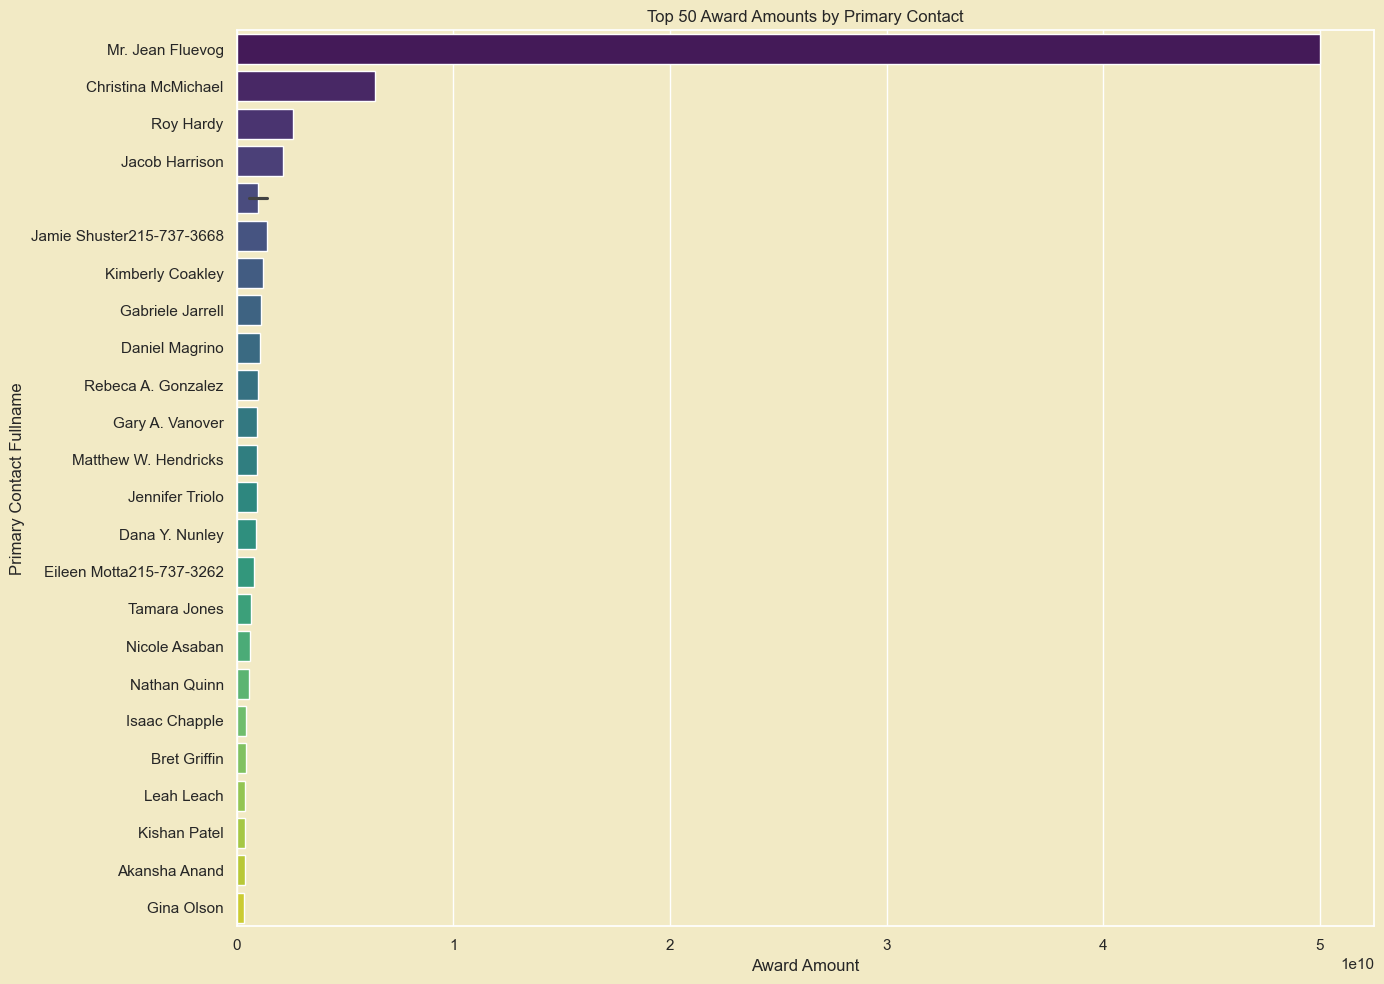

In [980]:
# Convert award_amount back to float for plotting
top_50_df['award_amount'] = top_50_df['award_amount'].str.replace(',', '').astype(float)

# Plot the top 50 award amounts
plt.figure(figsize=(14, 10))
sns.barplot(x='award_amount', y='primarycontactfullname', data=top_50_df, palette='viridis')
plt.title('Top 50 Award Amounts by Primary Contact')
plt.xlabel('Award Amount')
plt.ylabel('Primary Contact Fullname')
plt.tight_layout()
plt.show()

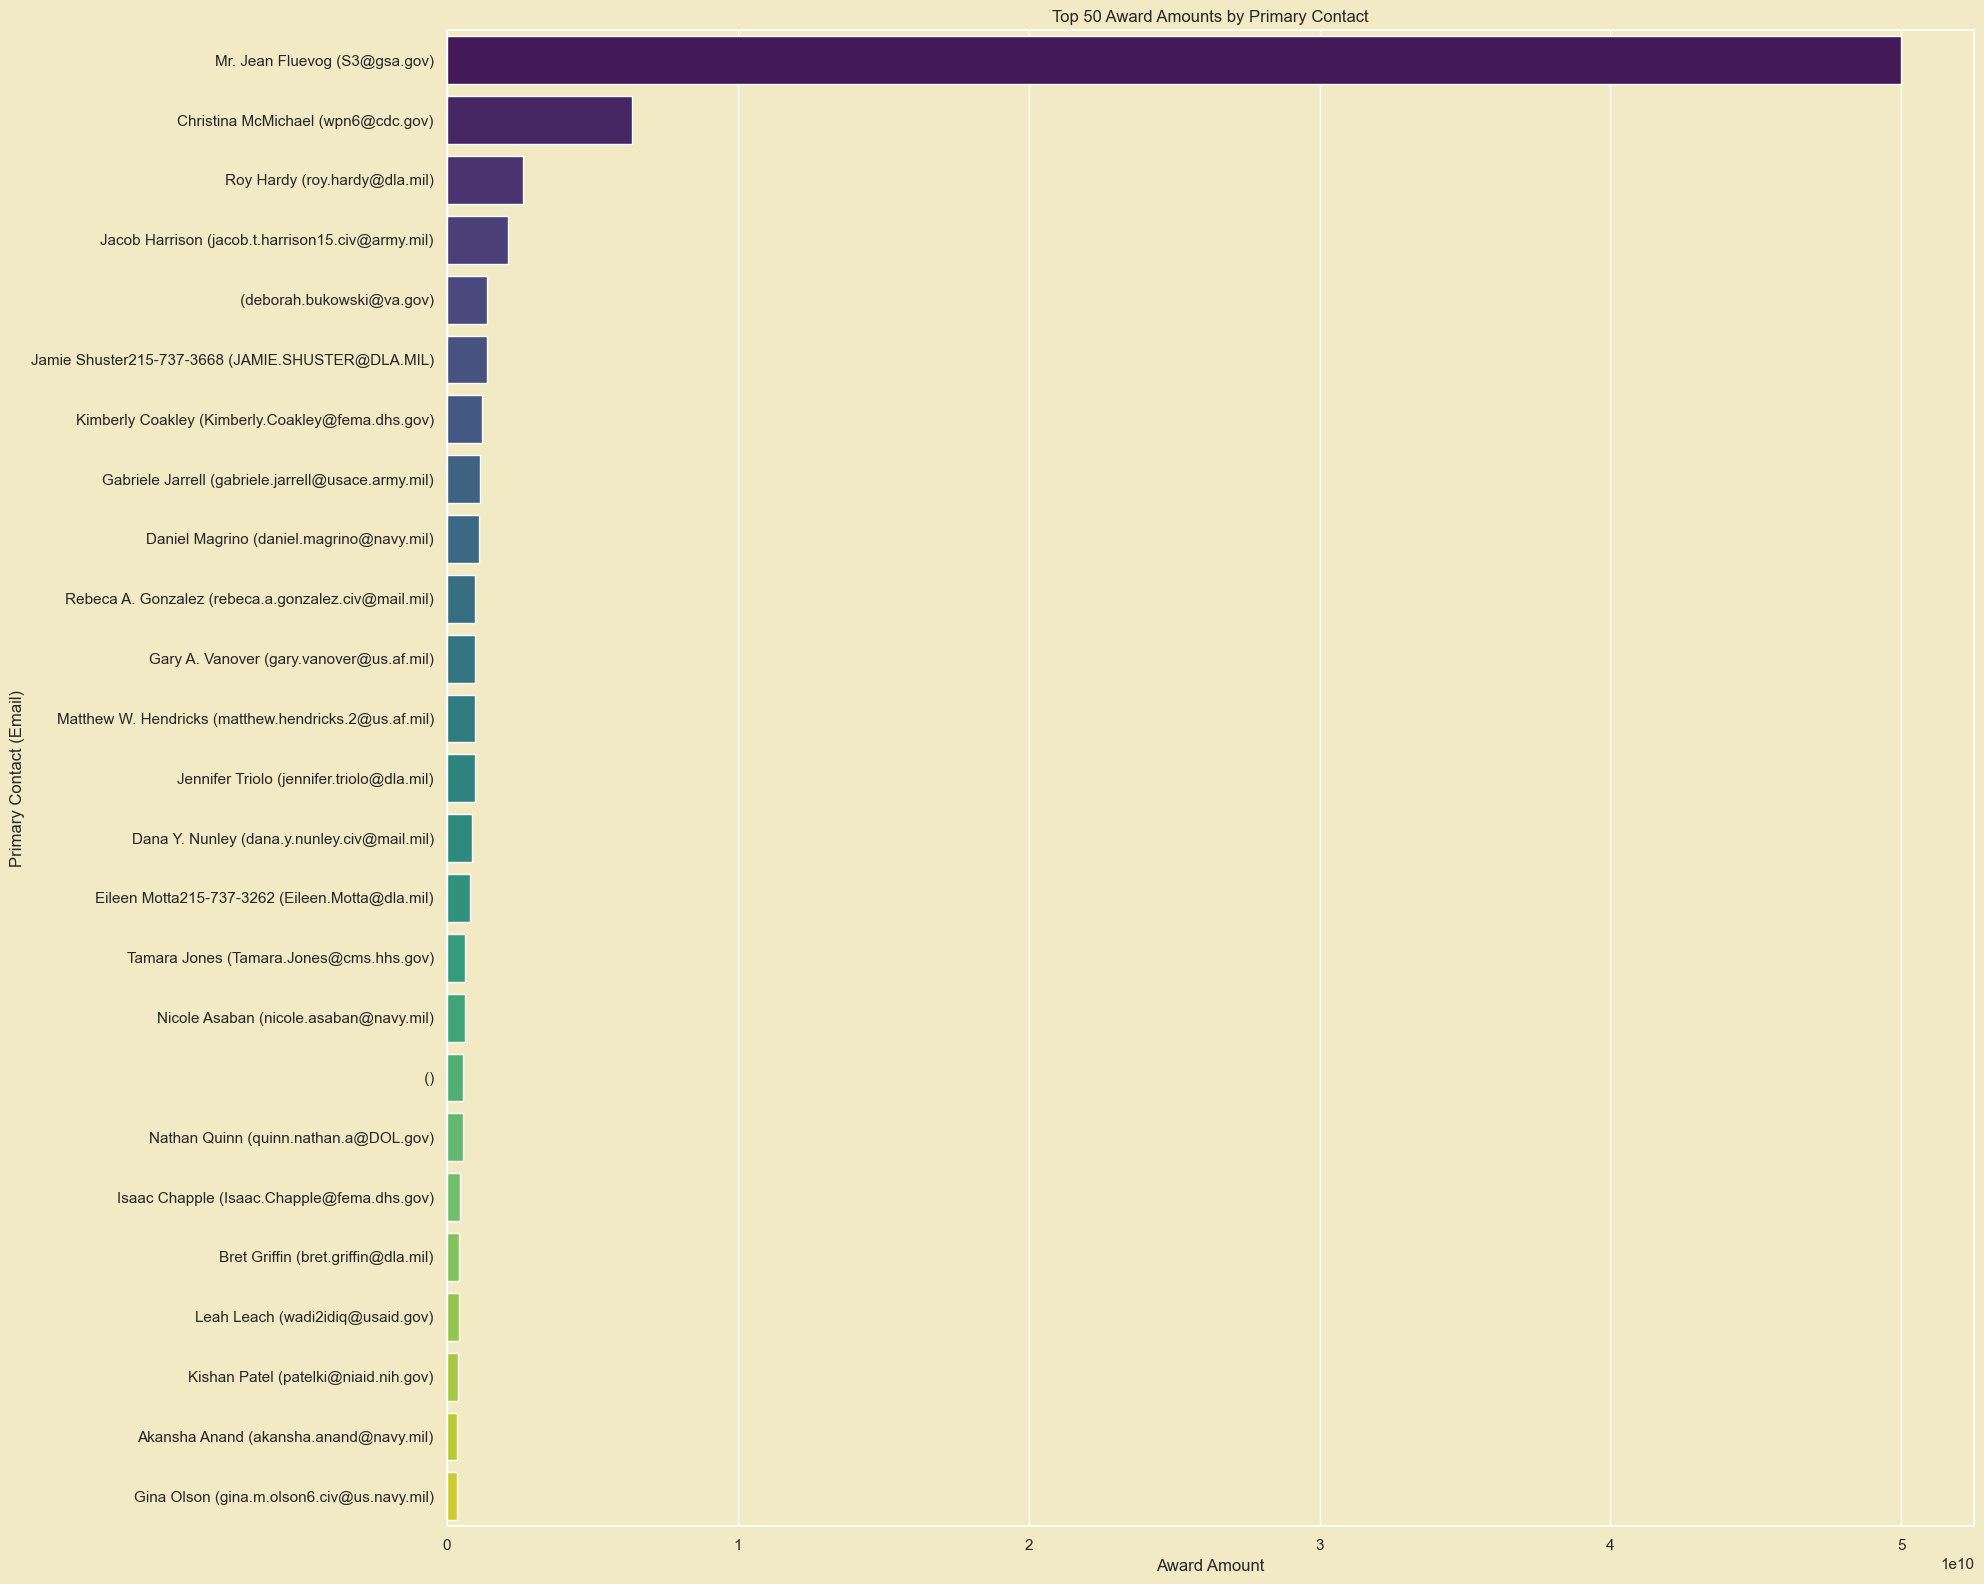

In [981]:
# Concatenate email addresses with primary contact names
top_50_df['contact_info'] = top_50_df['primarycontactfullname'] + ' (' + top_50_df['primarycontactemail'] + ')'

# Plot the top 50 award amounts
plt.figure(figsize=(20, 16))
sns.barplot(x='award_amount', y='contact_info', data=top_50_df, palette='viridis')
plt.title('Top 50 Award Amounts by Primary Contact')
plt.xlabel('Award Amount')
plt.ylabel('Primary Contact (Email)')
plt.tight_layout()
plt.show()

In [982]:
# Separate numeric and non-numeric columns
numeric_cols = df2022.select(pl.col(pl.Float64) | pl.col(pl.Int64)).columns
non_numeric_cols = df2022.select(pl.col(pl.Utf8)).columns
non_numeric_cols

['noticeid',
 'active',
 'award_',
 'primarycontacttitle',
 'primarycontactfullname',
 'primarycontactemail',
 'primarycontactphone',
 'primarycontactfax',
 'secondarycontacttitle',
 'secondarycontactfullname',
 'secondarycontactemail',
 'secondarycontactphone',
 'secondarycontactfax',
 'organizationtype',
 'additionalinfolink',
 'link']

In [983]:
# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
imputer

SimpleImputer()

In [984]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df2022_df):
    # Filter rows based on column: 'award_'
    df2022_df = df2022_df[(df2022_df['award_'].notna()) & (df2022_df['award_'] != "")]
    return df2022_df

# Loaded variable 'df2022' from kernel state
df2022_df = df2022.to_pandas()

df2022_df_clean = clean_data(df2022_df.copy())
df2022_df_clean.head()

,noticeid,title,sol_,department_ind_agency,cgac,sub_tier,fpds_code,office,aac_code,posteddate,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
0,bc5e5f04c91646579933a4c0bdc456a3,438,14850,13,17,45,54,942,1266,22481,...,,,OFFICE,44,480,139,36,,https://sam.gov/opp/bc5e5f04c91646579933a4c0bd...,0
8,7dca8a4e32a045e29704583e12fd871f,3517,21469,13,97,37,159,338,1388,4021,...,,,OFFICE,41,132,529,36,,https://sam.gov/opp/7dca8a4e32a045e29704583e12...,6875
10,4be36537709540ff82af05c5a4b6ee20,7446,6809,2,12,54,16,682,152,6785,...,8168231185,,OFFICE,11,625,168,36,,https://sam.gov/opp/4be36537709540ff82af05c5a4...,25615
19,423819fdf8bf4b2b93447e819f562efb,2959,23345,13,97,37,159,338,1397,22952,...,,,OFFICE,41,132,529,36,,https://sam.gov/opp/423819fdf8bf4b2b93447e819f...,0
23,1fccb64e3327482f9f6c9f996c2b5b10,3735,19626,13,97,37,159,323,1372,17317,...,,,OFFICE,53,514,311,36,,https://sam.gov/opp/1fccb64e3327482f9f6c9f996c...,0


In [985]:
df2022_df_clean.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award_', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [986]:
# Define features and target
X = df2022_df_clean.drop('award_', axis=1)
y = df2022_df_clean['award_']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [987]:
print(X_train)

                               noticeid  title   sol_  department_ind_agency  \
5709   391841bfb3064cd6808f748ee717a3d5   3041  23217                     13   
22906  0a1115b51c9d494ea95b5158fd6d84f8   3133  23150                     13   
22697  c12cd9ebbae644dd83c070e83e3555ed   1977  20553                     13   
26802  e4ca47ea06e141ad87872bbf602b6e43   2704  22848                     13   
13603  28645bfa9ae04bf2870ec5cc6a174353   5831  20669                     13   
...                                 ...    ...    ...                    ...   
19610  be569db8eed64e699ea6834be0459a73  14702  28406                     13   
27051  46150efeaf14423fabe85afd12352800  15181  10793                     13   
27274  d443f25deddd43f69e05c943bb65d305   3665  21167                     13   
28169  baf718b82e9249dcbdebc785287e6eb6   3312  25514                     13   
4557   f1621cefbd304078ad13750085c70351   1384   3629                     13   

       cgac  sub_tier  fpds_code  offic

In [988]:
print(X_test)

                               noticeid  title   sol_  department_ind_agency  \
12395  38fd31d5219543a0ae67622997a092a7   3750  21507                     13   
13788  9fa94bd460994f77b04634e87a2b116f  11299   1942                     32   
31883  c4f1e80fca8b40fb9a0aba03e7604f24  20440  26001                     13   
1904   ce12fe8ade0d463cafa47f8d4aee2858   1509  21224                     13   
24477  334ab8a17b864241bc8b7ab341fde888   4157  24034                     13   
...                                 ...    ...    ...                    ...   
30916  81e34d97a4e046d7bafec1eee6565ac7   5011   6173                     68   
20064  28b2272cf5924ed488548a01860db715   3477  21540                     13   
15661  67dcee4ef5d34622917fd14fc02aeecf   4481  23613                     13   
11441  9b80360834254df9b0d1da091cb995e4  19382   7479                     29   
12952  dc35422dee304baea8b91904043277f2   4683  22324                     13   

       cgac  sub_tier  fpds_code  offic

In [989]:
print(y_train)

5709       26680.00
22906      29293.69
22697     250000.00
26802     250000.00
13603     250000.00
            ...    
19610      60219.00
27051    2480579.11
27274     138750.00
28169      25675.15
4557       85138.55
Name: award_, Length: 4940, dtype: object


In [990]:
print(y_test)

12395          250000.00
13788             233550
31883            4620.00
1904            36527.50
24477          250000.00
              ...       
30916    125180.61000000
20064          250000.00
15661          144265.00
11441          116530.26
12952           26539.00
Name: award_, Length: 1235, dtype: object


In [991]:
# Function to clean currency columns
def clean_currency_columns(df):
    currency_cols = df.columns[df.apply(lambda col: col.astype(str).str.contains(r'\$').any())]
    for col in currency_cols:
        df[col] = df[col].str.replace('[\$,]', '', regex=True).astype(float)
    return df

# Clean X_train and X_test
X_train = clean_currency_columns(X_train)
X_test = clean_currency_columns(X_test)

In [992]:
# Train XGBoost model with enable_categorical=True
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    random_state=42,
    enable_categorical=True
)

In [993]:
X_train.columns

Index(['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac',
       'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type',
       'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle',
       'primarycontactfullname', 'primarycontactemail', 'primarycontactphone',
       'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

In [994]:
# Extract the first letter of each column name
first_letters = pd.Series(X_train.columns).str[0].str.lower()

# Count the number of variables by the first letter
first_letter_counts = first_letters.value_counts().reset_index()
first_letter_counts.columns = ['first_letter', 'count']

# Display the counts
print(first_letter_counts)

   first_letter  count
0             p     11
1             s     10
2             a      8
3             c      4
4             n      2
5             t      2
6             d      2
7             o      2
8             f      1
9             b      1
10            r      1
11            z      1
12            l      1


In [995]:
# Find columns starting with 'aw'
a_columns = [col for col in X_train.columns ]
print("Columns starting with 'a':", a_columns)

# Display the first few rows of X_train
print(X_train[a_columns])

Columns starting with 'a': ['noticeid', 'title', 'sol_', 'department_ind_agency', 'cgac', 'sub_tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside', 'responsedeadline', 'naicscode', 'classificationcode', 'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail', 'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle', 'secondarycontactfullname', 'secondarycontactemail', 'secondarycontactphone', 'secondarycontactfax', 'organizationtype', 'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link', 'description']
                               noticeid  title   sol_  department_ind_agency  \
5709   391841bfb3064cd6808f748ee717a3d5   3041  23217                     13   
22906  0a1115b51c9d494ea95b5158fd6d84f8   3133  23150                     13   
22697  c12

In [996]:
X_train=X_train[a_columns]
X_test=X_test[a_columns]

In [997]:
# Remove the specified columns
X_train = X_train.drop(columns=['noticeid', 'additionalinfolink', 'link'])
X_test = X_test.drop(columns=['noticeid', 'additionalinfolink', 'link'])

# Display the updated dataframes
print(X_train.head())
print(X_test.head())

       title   sol_  department_ind_agency  cgac  sub_tier  fpds_code  office  \
5709    3041  23217                     13    97        37        159     338   
22906   3133  23150                     13    97        37        159     338   
22697   1977  20553                     13    97        37        159     338   
26802   2704  22848                     13    97        37        159     338   
13603   5831  20669                     13    97        37        159     338   

       aac_code  posteddate  type  ...  secondarycontactfullname  \
5709       1397        5066     0  ...                             
22906      1397        6240     0  ...                             
22697      1386       14609     0  ...                             
26802      1394       11017     0  ...                             
13603      1386       15528     0  ...                             

       secondarycontactemail  secondarycontactphone  secondarycontactfax  \
5709                        

In [998]:
# Remove '$' and ',' then convert to float
#y_train = y_train.str.replace(r'[\$,]', '', regex=True).astype(float)
y_test = y_test.str.replace(r'[\$,]', '', regex=True).astype(float)

In [999]:
# Check the number of columns
print("Number of columns in X_train:", X_train.shape[1])
print("Number of columns in X_test:", X_test.shape[1])

Number of columns in X_train: 43
Number of columns in X_test: 43


In [1000]:
# Identify object columns
object_columns = X_train.select_dtypes(include=['object']).columns

# Clean columns containing '$'
for col in object_columns:
    if X_train[col].astype(str).str.contains('\$').any():
        X_train[col] = X_train[col].str.replace(r'[\$,]', '', regex=True).astype(float)
        X_test[col] = X_test[col].str.replace(r'[\$,]', '', regex=True).astype(float)

# Drop non-numeric columns without '$'
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test[X_train.columns]

# Ensure X_train and X_test have the same columns
X_test = X_test[X_train.columns]


In [1001]:
# Fit the XGBoost model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-rmse:72521608.09216
[1]	validation_0-rmse:76157132.37827
[2]	validation_0-rmse:80637927.92589
[3]	validation_0-rmse:84291703.73978
[4]	validation_0-rmse:90193925.98296
[5]	validation_0-rmse:93617012.05459
[6]	validation_0-rmse:97191140.80249
[7]	validation_0-rmse:99462675.66617
[8]	validation_0-rmse:101517703.26096
[9]	validation_0-rmse:102656541.67726
[10]	validation_0-rmse:104327623.81705
[11]	validation_0-rmse:104257034.85162
[12]	validation_0-rmse:104227630.82084
[13]	validation_0-rmse:104384865.06881
[14]	validation_0-rmse:104371974.76126
[15]	validation_0-rmse:104815319.62281
[16]	validation_0-rmse:104748992.77402
[17]	validation_0-rmse:105240334.72116
[18]	validation_0-rmse:104924932.09162
[19]	validation_0-rmse:105354175.97973
[20]	validation_0-rmse:105282471.75043
[21]	validation_0-rmse:105835974.59472
[22]	validation_0-rmse:105765083.14588
[23]	validation_0-rmse:105763708.35890
[24]	validation_0-rmse:106013872.56220
[25]	validation_0-rmse:105956752.34877
[26]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [1002]:
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

XGBoost MSE: 1.1636789898809388e+16, R2: -1.2275534903169905


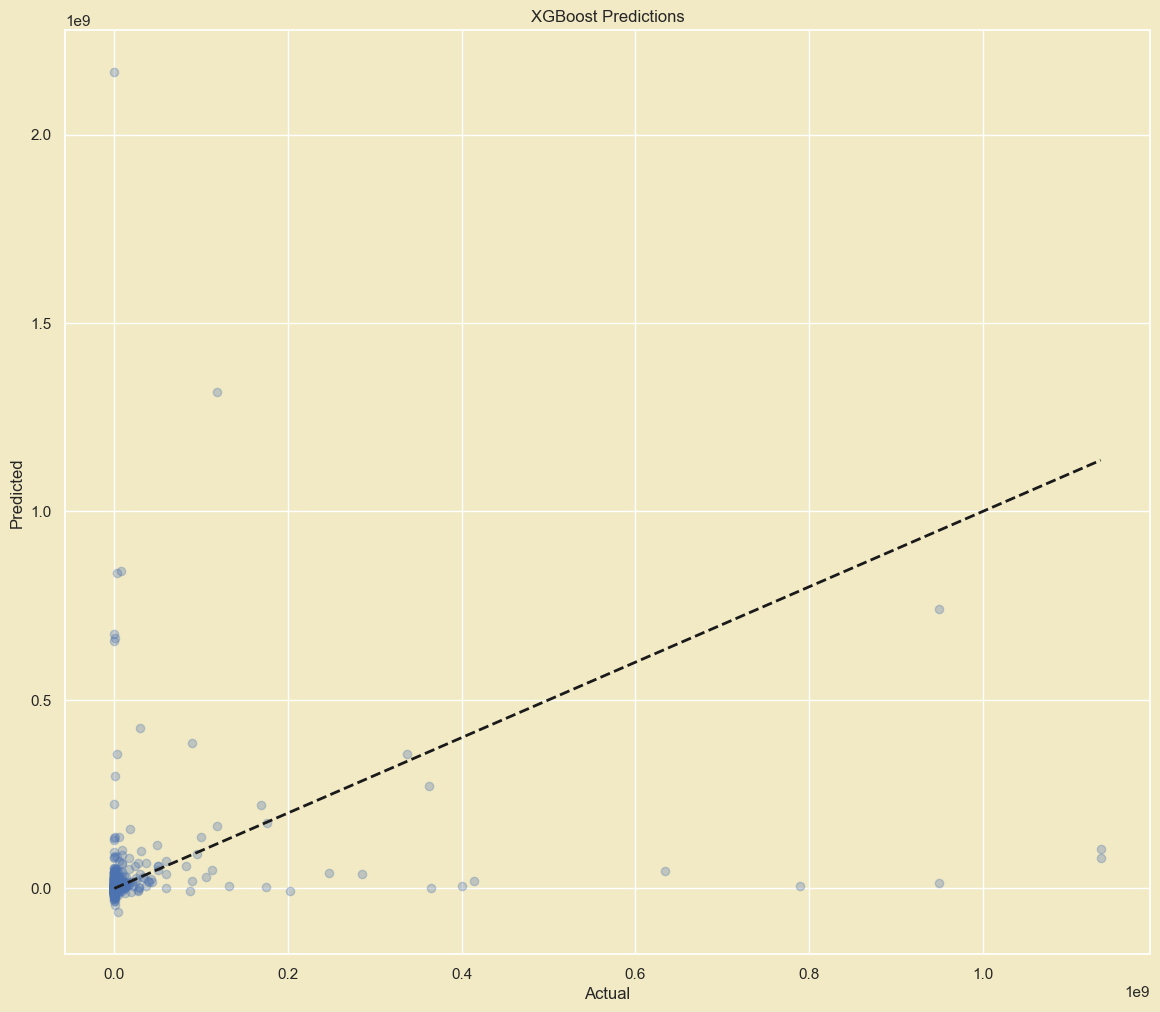

In [1003]:
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")

# Plot the results
plt.figure(figsize=(14, 12))
plt.scatter(y_test, xgb_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost Predictions')
plt.show()

In [1004]:
def clean_column_names(df):
    # Replace spaces and slashes with underscores
    df.columns = [col.replace(' ', '_').replace('/', '_') for col in df.columns]
    # Convert to lowercase
    df.columns = [col.lower() for col in df.columns]
    return df

# Assuming df2023 is your DataFrame
df2023 = clean_column_names(df)

In [1005]:
# Define prediction function to match provided columns
def predict_popularity(title, department_agency, cgac, sub_tier, fpds_code, office, aac_code, 
                       posted_date, contract_type, base_type, archive_type, darchive_date, 
                       set_aside_code, set_aside, response_deadline, naics_code, 
                       classification_code, pop_street_address, pop_city, pop_state,
                       pop_zip, pop_country, award_number, award_date, award_amount,
                       awardee, primary_contact_title, primary_contact_fullname,
                       primary_contact_email, primary_contact_phone, primary_contact_fax, 
                       secondary_contact_title, secondary_contact_fullname, secondary_contact_email, 
                       secondary_contact_phone, secondary_contact_fax, organization_type, state, 
                       city, zip_code, country_code, additional_info_link, link, description):

    # Hash specific text fields to match the model's expected input format
    title_hashed = hash(str(title)) % 10**8
    department_agency_hashed = hash(str(department_agency)) % 10**8
    sub_tier_hashed = hash(str(sub_tier)) % 10**8
    awardee_hashed = hash(str(awardee)) % 10**8

    # Create a DataFrame for the input, matching the column names in X
    input_data = pd.DataFrame([[
        title_hashed, department_agency_hashed, cgac, sub_tier_hashed, fpds_code,
        office, aac_code, posted_date, contract_type, base_type, archive_type,
        set_aside_code, set_aside, response_deadline, naics_code, classification_code,
        pop_street_address, pop_city, pop_state, pop_zip, pop_country,
        award_number, award_date, award_amount, awardee_hashed, primary_contact_title,
        primary_contact_fullname, primary_contact_email, primary_contact_phone,
        primary_contact_fax, secondary_contact_title, secondary_contact_fullname,
        secondary_contact_email, secondary_contact_phone, secondary_contact_fax,
        organization_type, state, city, zip_code, country_code, additional_info_link,
        link, description
    ]], columns=X.columns)

    # Define numeric columns, if any, to normalize
    # (Assume 'award_amount' as a numerical example, modify as needed based on your data)
    numerical_cols = ['award_amount']
    input_data[numerical_cols] = (input_data[numerical_cols] - X[numerical_cols].mean()) / X[numerical_cols].std()

    # Return the DataFrame ready for prediction
    return input_data


In [1006]:
X_train.dtypes.to_frame('Data Type')

,Data Type
title,int64
sol_,int64
department_ind_agency,int64
cgac,int64
sub_tier,int64
fpds_code,int64
office,int64
aac_code,int64
posteddate,int64
type,int64


In [1007]:
# Missing values in each row
missing_values_per_row = X_train.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (X_train.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

4940 row(s) have 0 missing values
Total number of rows with missing values: 0


In [1008]:
dist_numerical_cols = X_train.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = X_train.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (X_train.isnull().mean() * 100).round(2)

The output shows that all numeric columns have a missing value percentage of 0, indicating that **there are no missing values** in these columns.

To gain further insights into the data, we used the `describe()` method to generate a comprehensive statistical summary of the numerical columns.

**👉 Distribution of numerical columns**

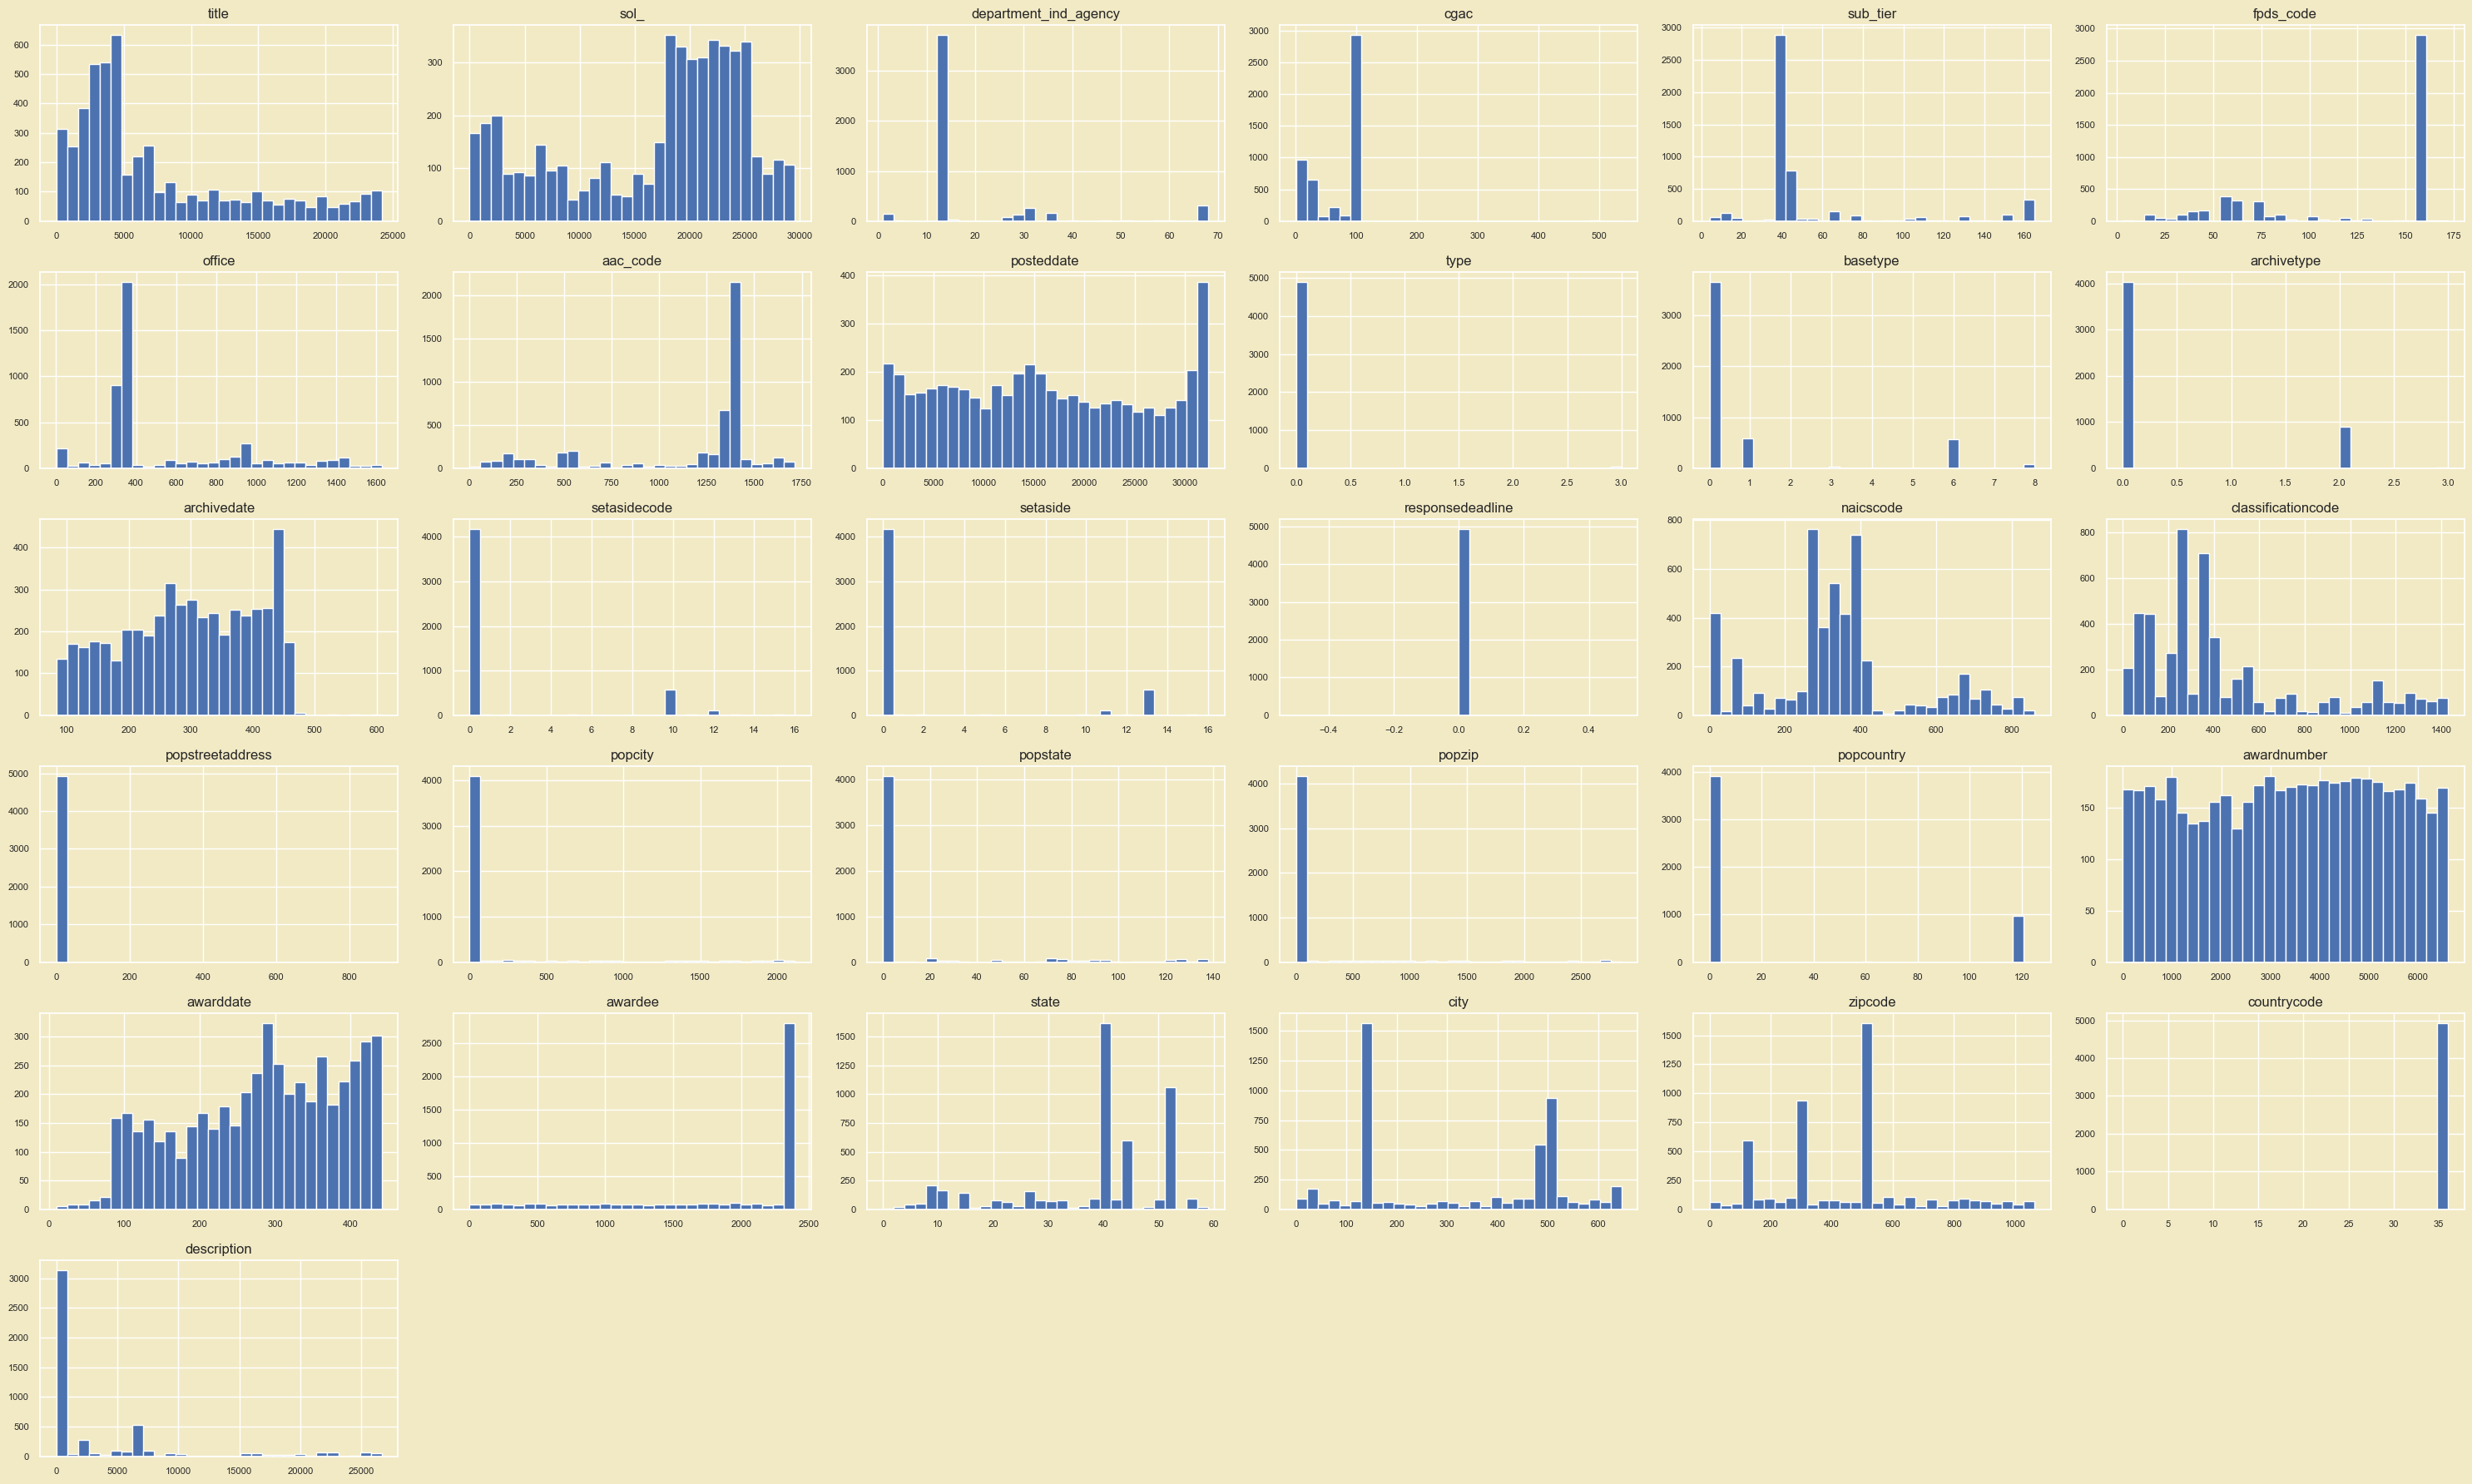

In [1009]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
X_train.hist(figsize=(30,18), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

<Figure size 3200x1500 with 0 Axes>

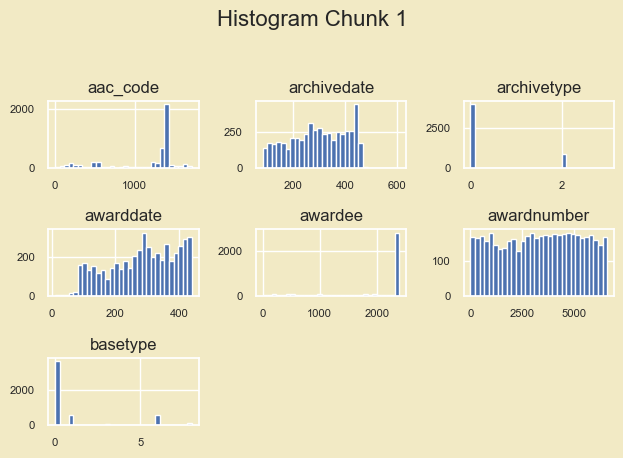

<Figure size 3200x1500 with 0 Axes>

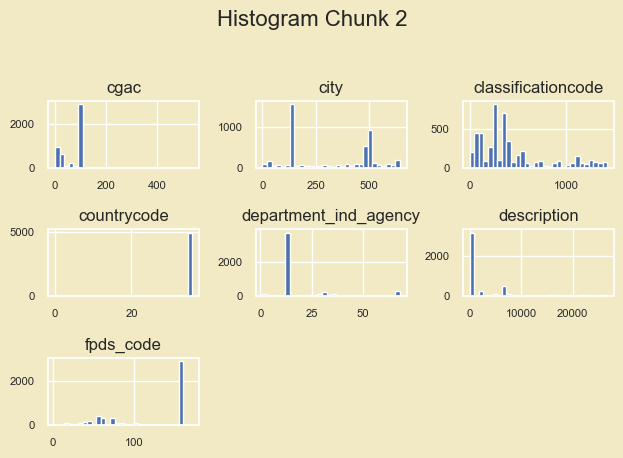

<Figure size 3200x1500 with 0 Axes>

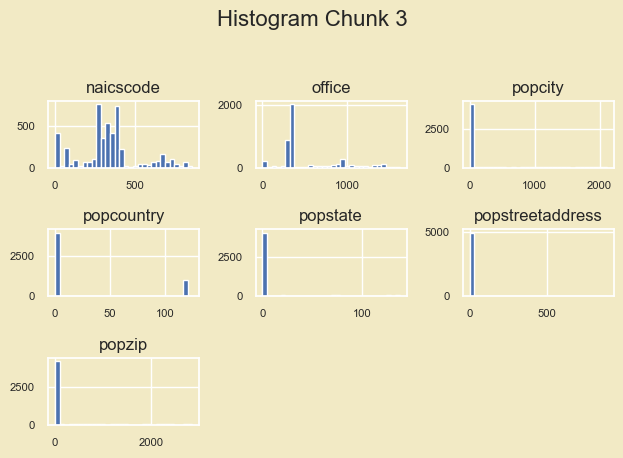

<Figure size 3200x1500 with 0 Axes>

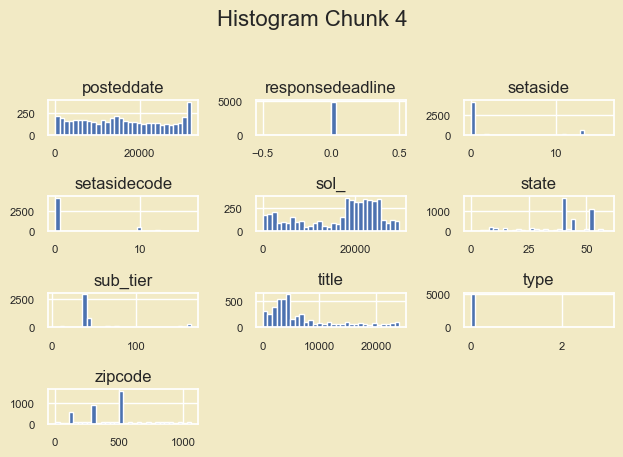

In [1010]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# Sort the columns by name
sorted_columns = sorted(X_train.columns)

# Split columns into four roughly equal parts
num_chunks = 4
chunk_size = len(sorted_columns) // num_chunks
chunks = [sorted_columns[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]

# If there are remaining columns, add them to the last chunk
if len(sorted_columns) % num_chunks != 0:
    chunks[-1].extend(sorted_columns[num_chunks * chunk_size:])

# Plot histograms for each chunk
for idx, chunk in enumerate(chunks, 1):
    plt.figure(figsize=(32, 15))
    X_train[chunk].hist(bins=30, xlabelsize=8, ylabelsize=8)
    plt.suptitle(f'Histogram Chunk {idx}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [1011]:
unique_values = X_train.nunique()
missing_values = X_train.isnull().sum()

summary = pd.DataFrame({
    'Unique Values': unique_values,
    'Missing Values': missing_values
})

In [1012]:
summary_sorted = summary.sort_values(by='Unique Values', ascending=True)

print(summary_sorted)

                       Unique Values  Missing Values
responsedeadline                   1               0
type                               2               0
archivetype                        3               0
popstreetaddress                   4               0
basetype                           5               0
countrycode                        7               0
setasidecode                      14               0
setaside                          14               0
popcountry                        32               0
department_ind_agency             34               0
cgac                              36               0
state                             55               0
popstate                          58               0
sub_tier                          77               0
fpds_code                         77               0
city                             324               0
archivedate                      366               0
awarddate                        383          

In [1013]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4940 entries, 5709 to 4557
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   title                  4940 non-null   int64
 1   sol_                   4940 non-null   int64
 2   department_ind_agency  4940 non-null   int64
 3   cgac                   4940 non-null   int64
 4   sub_tier               4940 non-null   int64
 5   fpds_code              4940 non-null   int64
 6   office                 4940 non-null   int64
 7   aac_code               4940 non-null   int64
 8   posteddate             4940 non-null   int64
 9   type                   4940 non-null   int64
 10  basetype               4940 non-null   int64
 11  archivetype            4940 non-null   int64
 12  archivedate            4940 non-null   int64
 13  setasidecode           4940 non-null   int64
 14  setaside               4940 non-null   int64
 15  responsedeadline       4940 non-null   i

In [1014]:
# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Fit Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"Ridge Regression MSE: {ridge_mse}, R2: {ridge_r2}")

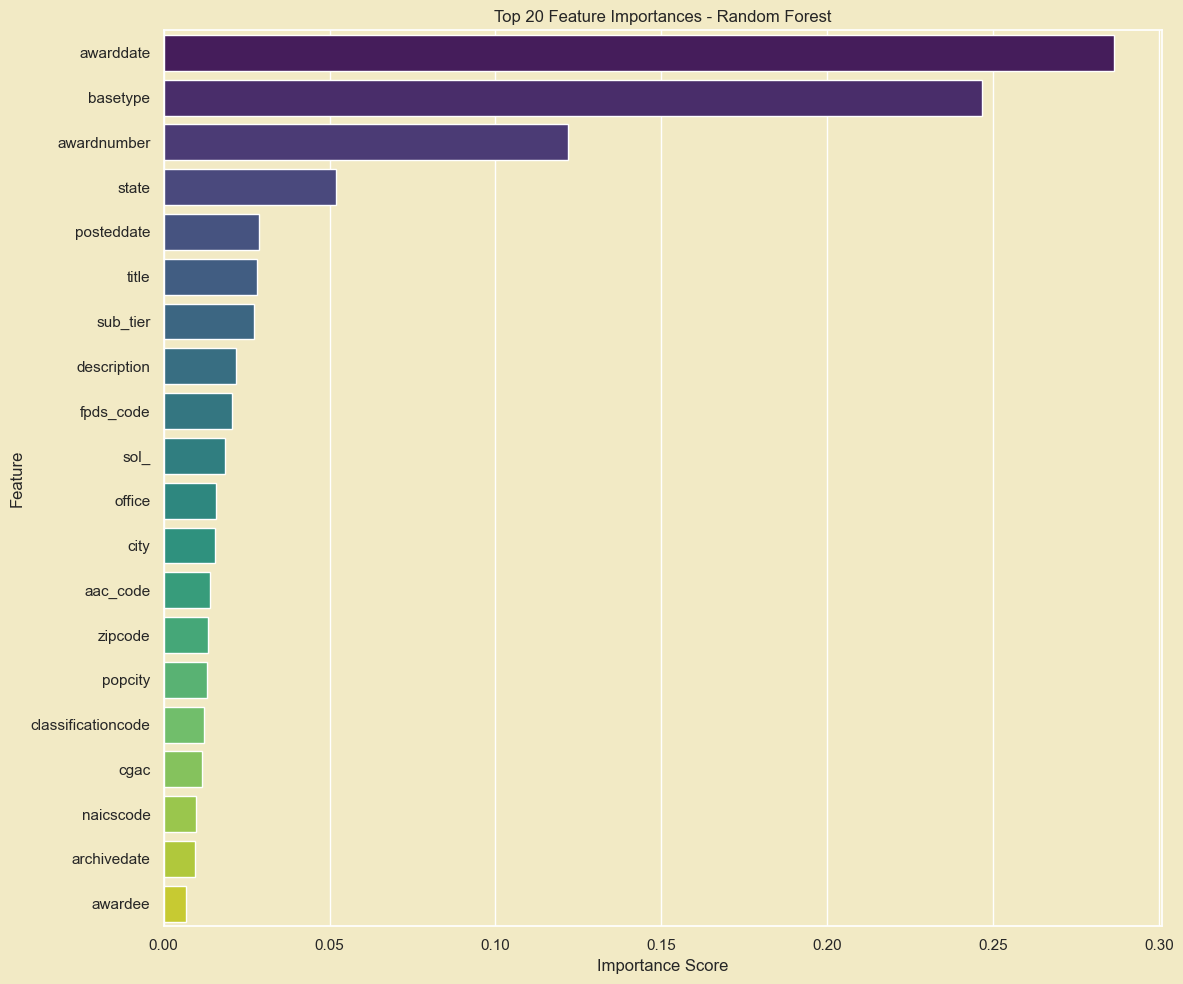

In [ ]:
# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#F2EAC5", "figure.facecolor": "#F2EAC5"})

# 1. Feature Importance for Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)  # Top 20 features

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

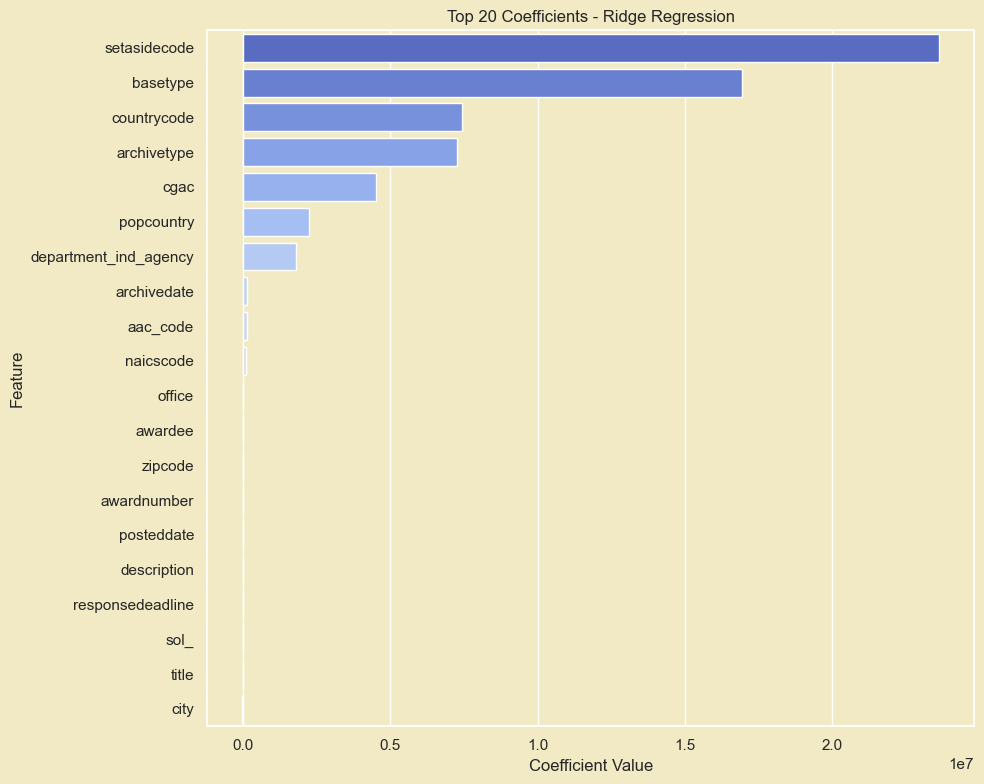

In [ ]:
# 2. Coefficient Analysis for Ridge Regression
coefficients = ridge_model.coef_
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False).head(20)  # Top 20 positive coefficients

plt.figure(figsize=(10, 8))
sns.barplot(x='coefficient', y='feature', data=coef_df, palette='coolwarm')
plt.title('Top 20 Coefficients - Ridge Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# 3. SHAP Values for Model Explainability
# Random Forest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")
plt.title('SHAP Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

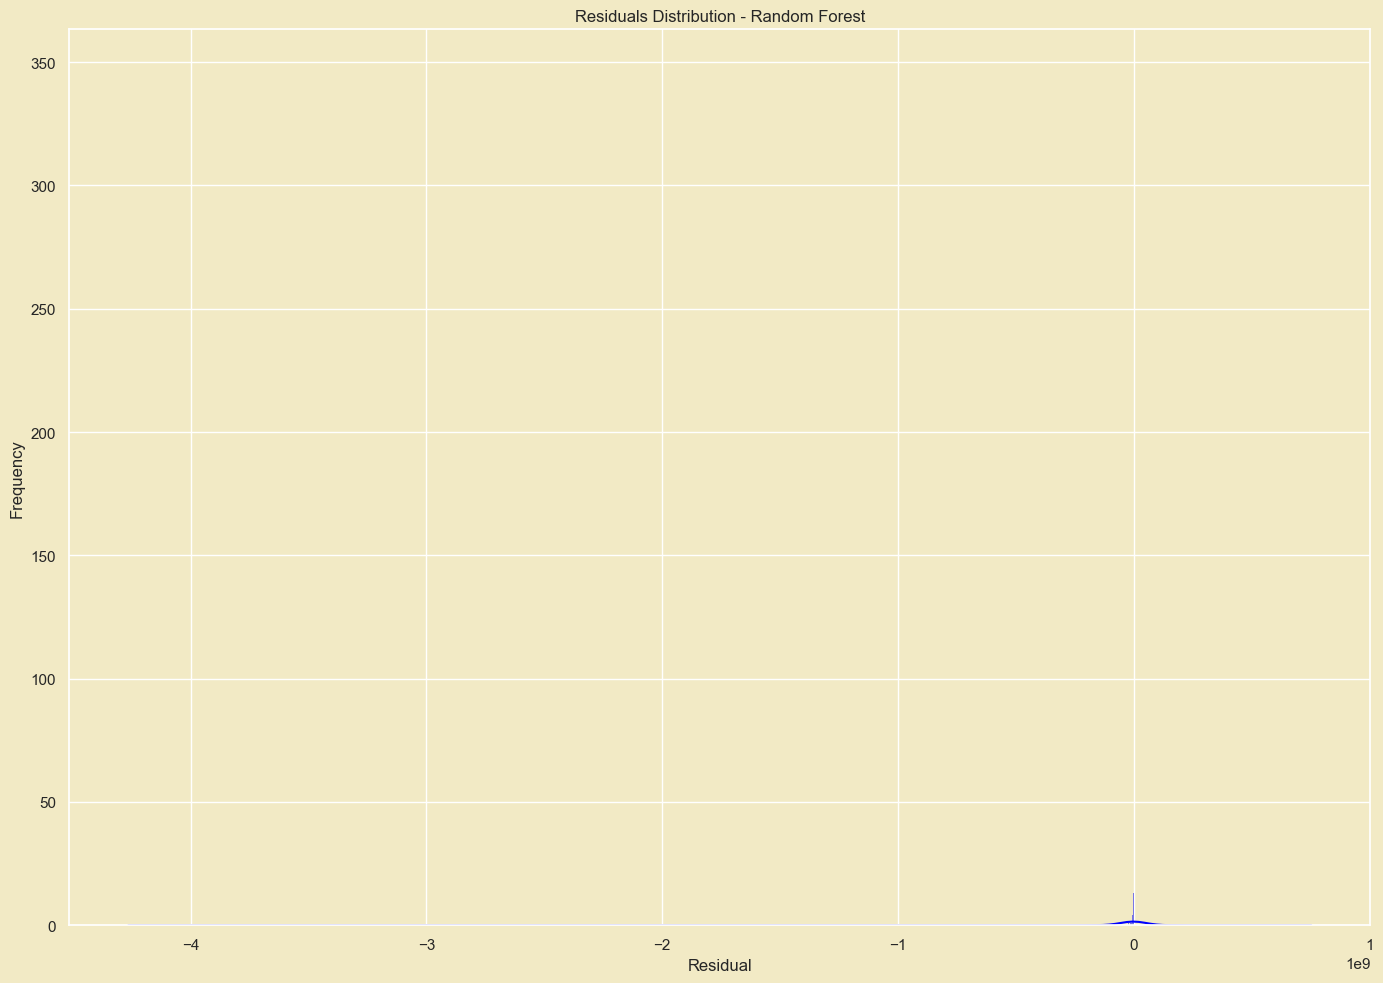

In [ ]:
# 4. Residual Plots
# Random Forest Residuals
rf_residuals = y_test - rf_predictions
plt.figure(figsize=(14, 10))
sns.histplot(rf_residuals, kde=True, color='blue')
plt.title('Residuals Distribution - Random Forest')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

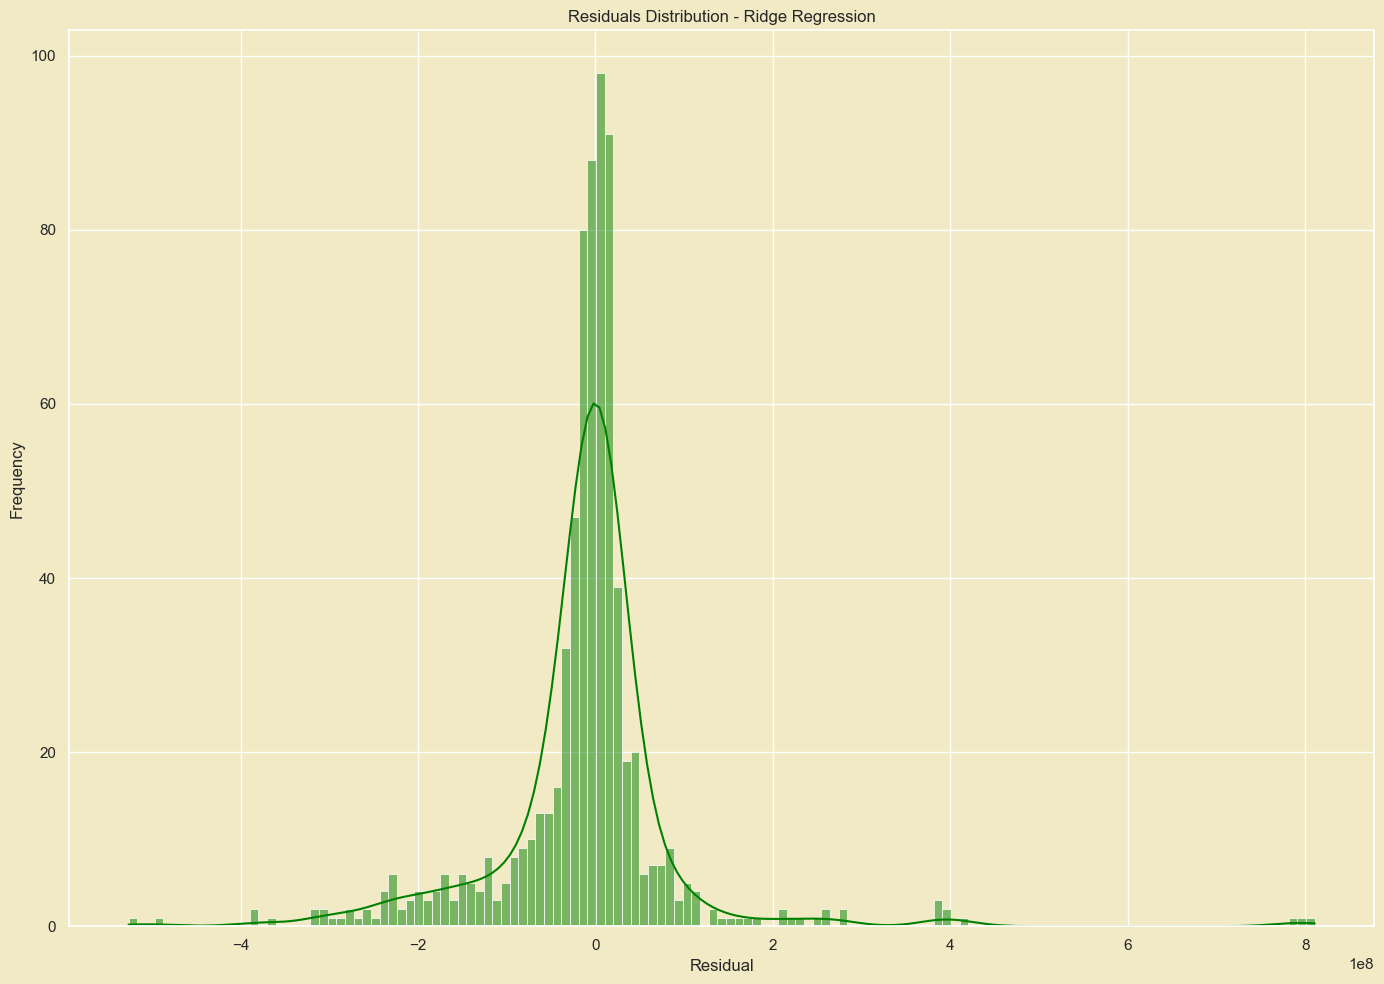

In [ ]:
# Ridge Regression Residuals
ridge_residuals = y_test - ridge_predictions
plt.figure(figsize=(14, 10))
sns.histplot(ridge_residuals, kde=True, color='green')
plt.title('Residuals Distribution - Ridge Regression')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Actual vs. Predicted - Random Forest')

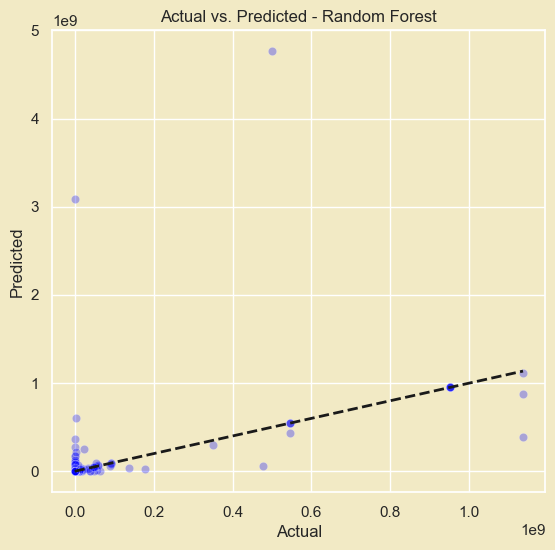

In [ ]:
# 5. Actual vs. Predicted Scatter Plots
plt.figure(figsize=(20, 12))

# Random Forest
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=rf_predictions, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Random Forest')

# Ridge Regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=ridge_predictions, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted - Ridge Regression')

plt.tight_layout()
plt.show()

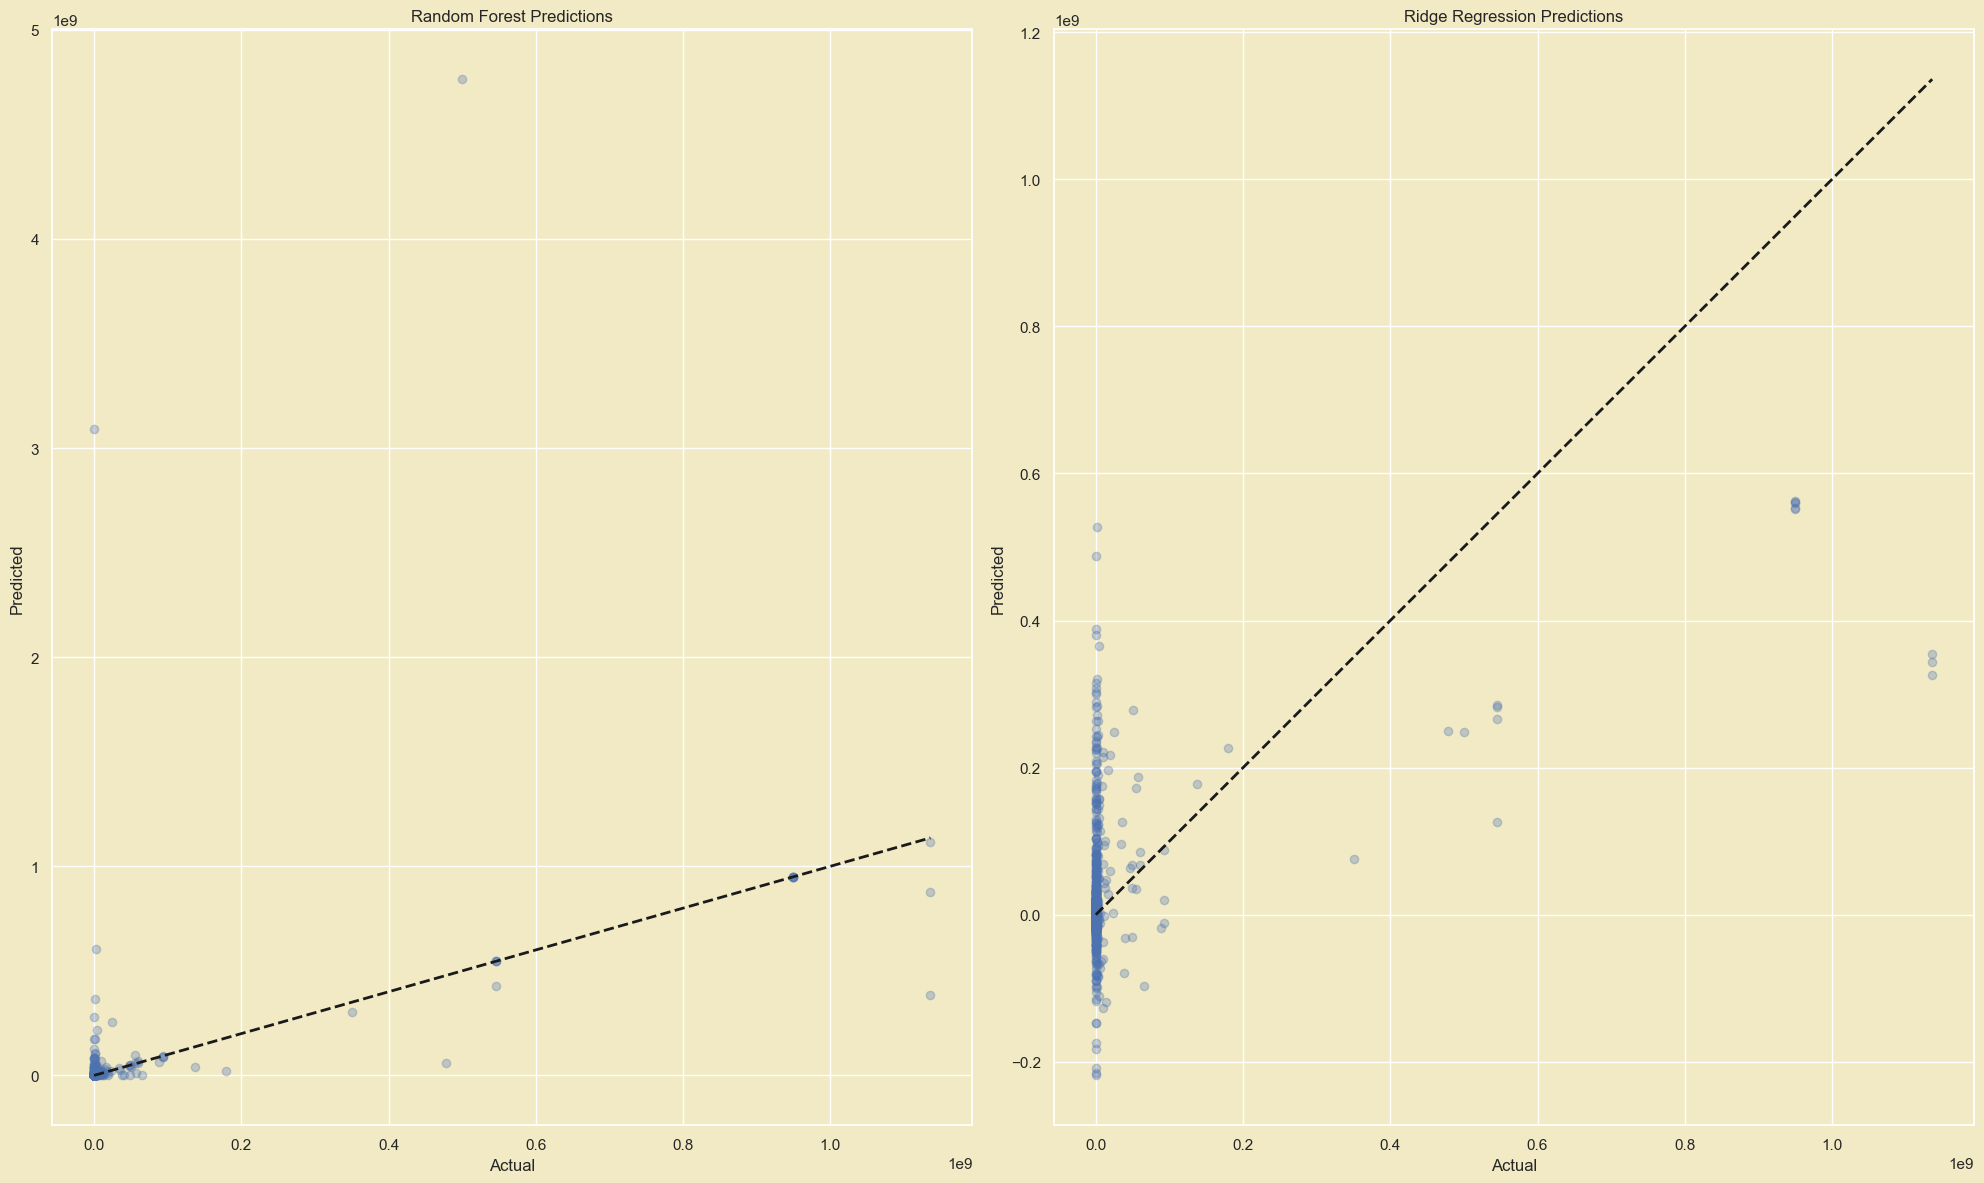

In [ ]:
# Plot the results
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression Predictions')

plt.tight_layout()
plt.show()